In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
rawTracePerson1 = sio.loadmat("Neural_Signal/data/Person1/rawTracePerson1.mat", variable_names = ["Track", "dataTrial"])
rawTracePerson2 = sio.loadmat("Neural_Signal/data/Person2/rawTracePerson2.mat", variable_names = ["Track", "dataTrial"])
rawTracePerson3 = sio.loadmat("Neural_Signal/data/Person3/rawTracePerson3.mat", variable_names = ["Track", "dataTrial"])
rawTracePerson4 = sio.loadmat("Neural_Signal/data/Person4/rawTracePerson4.mat", variable_names = ["Track", "dataTrial"])
OSPerson1 = sio.loadmat("Neural_Signal/data/Person1/OSPerson1.mat")
OSPerson2 = sio.loadmat("Neural_Signal/data/Person2/OSPerson2.mat")
OSPerson3 = sio.loadmat("Neural_Signal/data/Person3/OSPerson3.mat")
OSPerson4 = sio.loadmat("Neural_Signal/data/Person4/OSPerson4.mat")

track1, data_trial1 =  rawTracePerson1["Track"], rawTracePerson1["dataTrial"]
track2, data_trial2 =  rawTracePerson2["Track"], rawTracePerson2["dataTrial"]
track3, data_trial3 =  rawTracePerson3["Track"], rawTracePerson3["dataTrial"]
track4, data_trial4 =  rawTracePerson4["Track"], rawTracePerson4["dataTrial"]
trials = np.concatenate((track1, track2, track3, track4), axis=1)[0]
# trials = track1[0]
trials.shape

(100,)

In [3]:
trial_datas = np.concatenate((OSPerson1["OS"][30:,4:14,:,[22, 25, 23]], 
                              OSPerson2["OS"][30:,4:14,:,[22, 25, 23]], 
                              OSPerson3["OS"][30:,4:14,:,[22, 25, 23]],
                              OSPerson4["OS"][30:,4:14,:,[22, 25, 23]]),
                             axis=2)
# trial_datas = OSPerson1["OS"][30:,4:14,:,0:16]
trial_datas.shape

(6, 10, 100, 3)

In [4]:
trial_train_data = trial_datas.transpose([2,0,1,3])
trial_train_data = trial_train_data.reshape((trial_train_data.shape[0], -1))
trial_train_data = torch.from_numpy(trial_train_data.astype(np.float32))
# trial_train_data = trial_train_data.reshape((100,1,10,36,20))

In [5]:
trial_test_data = trial_train_data[80:,:]
trial_train_data = trial_train_data[0:80,:]
trial_train_data.shape

torch.Size([80, 180])

In [6]:
trial_type = np.zeros(len(trials))

for num_trial in range(len(trials)):
    if trials[num_trial] <= 10:
        trial_type[num_trial] = 1
test_labels = torch.from_numpy(trial_type.astype(np.float32))[80:] 
trial_type = torch.from_numpy(trial_type.astype(np.float32))[0:80]
trial_type = trial_type.reshape(80,1)
trial_type[0].size()

torch.Size([1])

In [7]:
# class MultiLayerCNN(nn.Module):
#     def __init__(self, n_hidden=64):
#         super(MultiLayerCNN, self).__init__()
#         self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
#         self.relu = nn.ReLU()
#         self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(2880, 128)
#         self.fc2 = nn.Linear(128, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = x.view(-1)
#         x = self.fc1(x)
#         x = nn.ReLU()(x)
        
#         x = self.fc2(x)
#         x = self.sigmoid(x)
        
#         return x

In [8]:
# cnn_model = MultiLayerCNN()

In [9]:
# trial_type = trial_type.to("cuda")
# trial_test_data = trial_test_data.to("cuda")
# trial_train_data = trial_train_data.to("cuda")
# model = model.to("cuda")

In [10]:
# 构建MLP模型
class MLP(nn.Module):
    def __init__(self, in_channel):
        super(MLP, self).__init__()
        
        # 定义全连接层
        self.fc1 = nn.Linear(in_channel, 512)
        self.fc2 = nn.Linear(512,  256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        
        # 定义dropout层
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# 创建MLP模型实例
model = MLP(trial_train_data.shape[-1])
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
model

MLP(
  (fc1): Linear(in_features=180, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [12]:
# 定义损失函数和优化器
from tqdm.notebook import tqdm
acc_list = []
for epoch in tqdm(range(200)):
    running_loss = 0.0
    model.train()
    
    for i in range(len(trial_train_data)):
        # 获取输入数据和标签
        inputs = trial_train_data[i]
        labels = trial_type[i]
        
        # 清空梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = model(inputs)
        # print(outputs, labels)
        
        # 计算损失函数
        loss = criterion(outputs, labels)
        
        # 反向传播和优化

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    model.eval()
    pred = [1 if model(trial_test_data[i])>0.5 else 0 for i in range(len(trial_test_data))]
    acc = accuracy_score(pred, test_labels)
    acc_list.append(acc)
    print(f"{epoch}: {acc}")

  0%|          | 0/200 [00:00<?, ?it/s]

0: 0.3
1: 0.3
2: 0.3
3: 0.3


4: 0.3
5: 0.3
6: 0.3
7: 0.3
8: 0.3
9: 0.3
10: 0.3
11: 0.3
12: 0.3
13: 0.3
14: 0.3
15: 0.3
16: 0.3
17: 0.3
18: 0.3
19: 0.3
20: 0.3
21: 0.3
22: 0.3
23: 0.3
24: 0.3
25: 0.3
26: 0.3
27: 0.3
28: 0.3
29: 0.35
30: 0.3
31: 0.3
32: 0.35
33: 0.4
34: 0.4
35: 0.45
36: 0.45
37: 0.45
38: 0.45
39: 0.45
40: 0.45
41: 0.45
42: 0.45
43: 0.45
44: 0.45
45: 0.45
46: 0.4
47: 0.5
48: 0.45
49: 0.4
50: 0.45
51: 0.45
52: 0.5
53: 0.5
54: 0.5
55: 0.45
56: 0.45
57: 0.4
58: 0.5
59: 0.4
60: 0.4
61: 0.4
62: 0.45
63: 0.35
64: 0.45
65: 0.5
66: 0.5
67: 0.5
68: 0.45
69: 0.45
70: 0.5
71: 0.45
72: 0.5
73: 0.45
74: 0.5
75: 0.5
76: 0.5
77: 0.45
78: 0.45
79: 0.5
80: 0.45
81: 0.4
82: 0.5
83: 0.55
84: 0.4
85: 0.6
86: 0.4
87: 0.5
88: 0.5
89: 0.45
90: 0.5
91: 0.4
92: 0.65
93: 0.45
94: 0.4
95: 0.5
96: 0.4
97: 0.4
98: 0.4
99: 0.6
100: 0.4
101: 0.4
102: 0.4
103: 0.4
104: 0.45
105: 0.5
106: 0.45
107: 0.4
108: 0.4
109: 0.4
110: 0.55
111: 0.45
112: 0.35
113: 0.5
114: 0.35
115: 0.45
116: 0.45
117: 0.4
118: 0.65
119: 0.45
120: 0.4
121: 0.

In [13]:
model.eval()
pred = [1 if model(trial_train_data[i])>0.5 else 0 for i in range(len(trial_train_data))]
acc = accuracy_score(pred, trial_type)
acc

0.9875

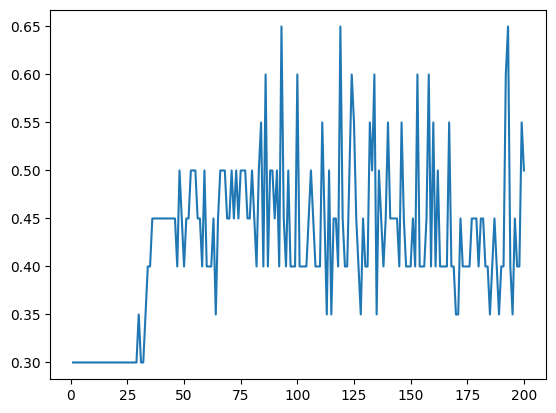

In [14]:
from matplotlib import pyplot as plt

x_axis = np.linspace(1, 200, 200)
plt.plot(x_axis, acc_list)
plt.show()